<a href="https://colab.research.google.com/github/akshithadev19/projects_lab_submissions/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-03-10 14:47:09--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.48MB/s    in 0.6s    

2025-03-10 14:47:10 (1.48 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


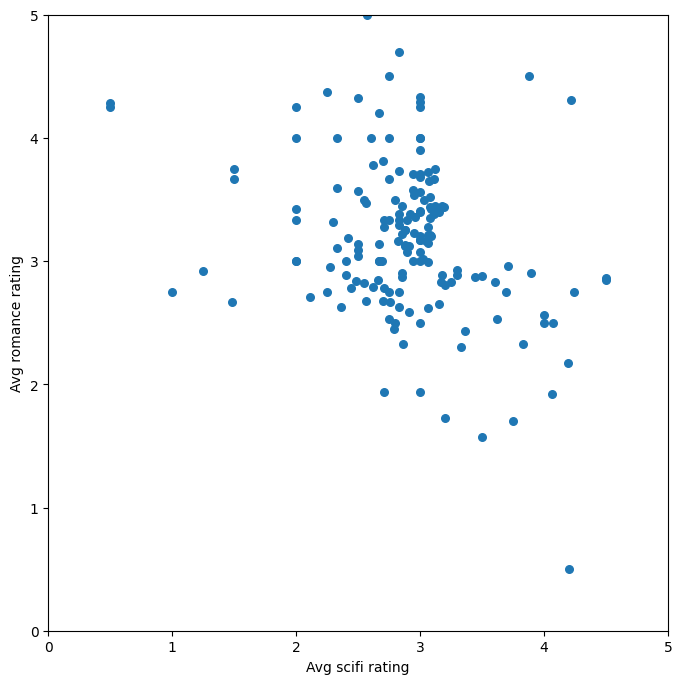

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

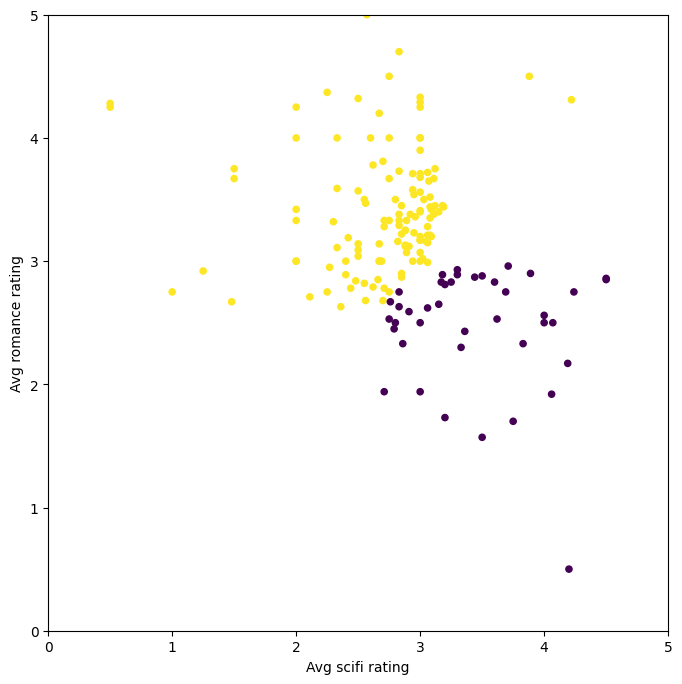

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

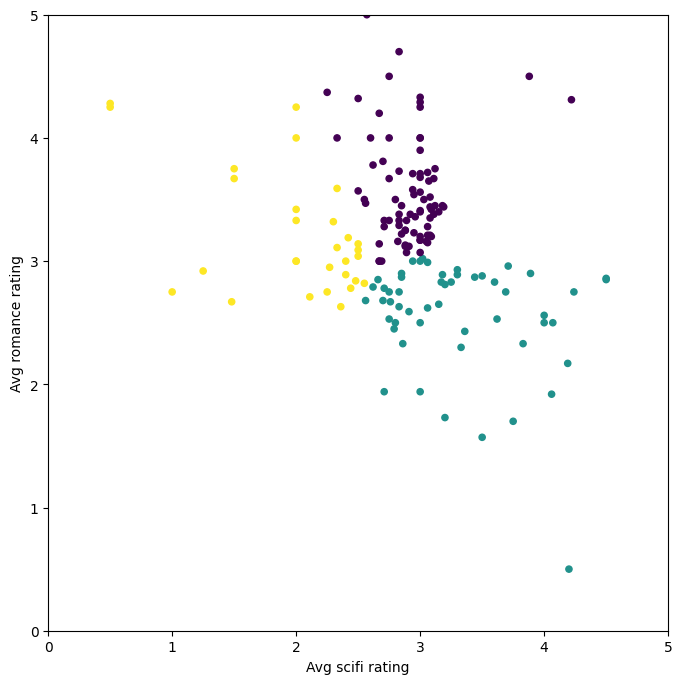

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


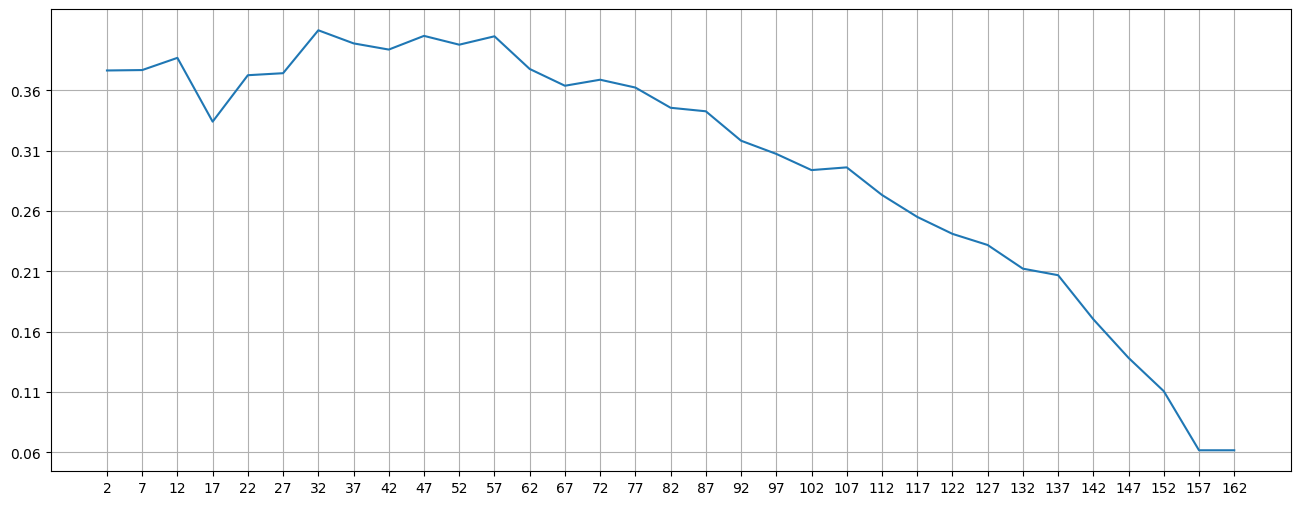

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



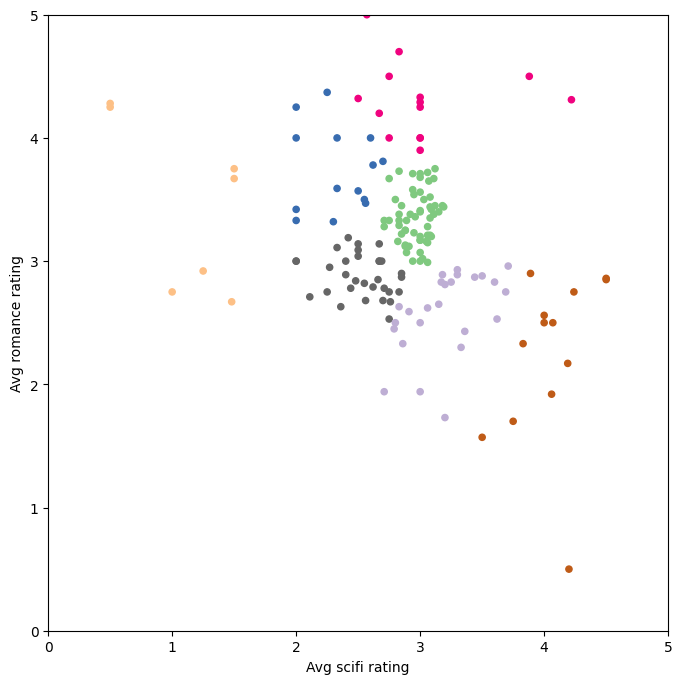

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


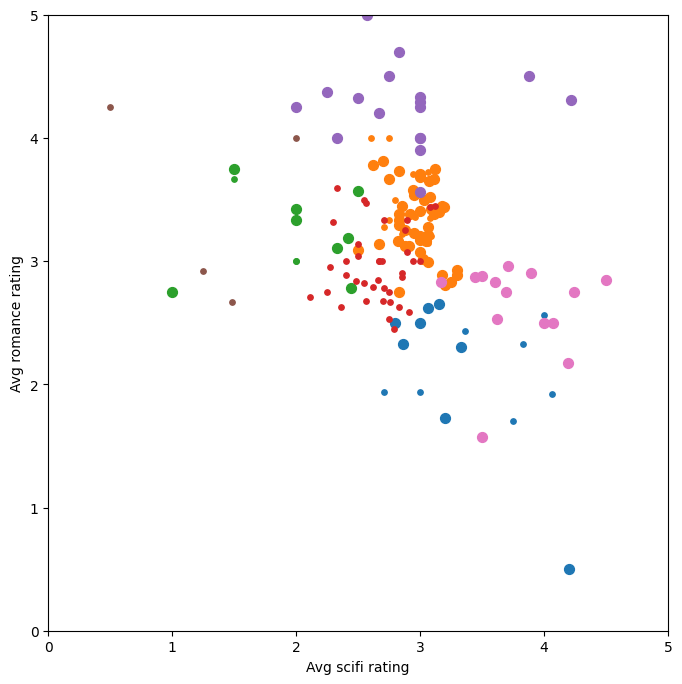

In [15]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

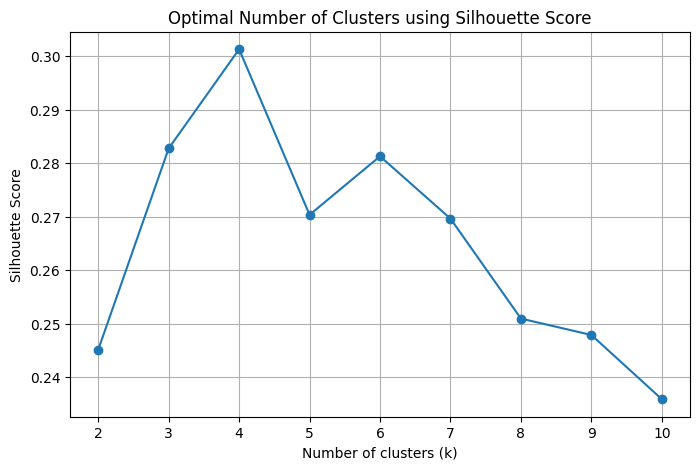

Optimal number of clusters: 4


In [16]:
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract features for clustering
X_with_action = biased_dataset_3_genres[['avg_scifi_rating', 'avg_romance_rating', 'avg_action_rating']].values

# Define the range of k values to test
k_values = range(2, 11)  # Trying k from 2 to 10

# Function to compute silhouette scores for different k values
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_with_action)
    score = silhouette_score(X_with_action, cluster_labels)
    silhouette_scores.append(score)

# Plot silhouette score vs. number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters using Silhouette Score")
plt.grid(True)
plt.show()

# Find the best k value
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [17]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
import pandas as pd

# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count ratings for each movie
    user_movie_ratings = pd.concat([user_movie_ratings, user_movie_ratings.count().to_frame().T], ignore_index=True)

    # 2- Sort movies by number of ratings
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)

    # 3- Select the top `max_number_of_movies`
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the users who rate movies the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# Load the dataset
ratings = pd.read_csv("ml-latest-small/ratings.csv")

# Create the user-movie ratings matrix
user_movie_ratings = ratings.pivot(index="userId", columns="movieId", values="rating")

# Choose the number of movies and users
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print("Dataset dimensions: ", most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions:  (18, 30)
movieId  356   318   296   593   2571  260   480   110   589   527   ...  \
479       5.0   5.0   4.0   4.5   5.0   4.5   5.0   5.0   4.5   5.0  ...   
473       3.0   5.0   4.0   4.5   4.5   4.0   4.5   3.0   4.0   5.0  ...   
67        3.5   3.0   2.0   3.5   4.5   5.0   3.5   2.5   3.5   4.0  ...   
413       5.0   5.0   5.0   4.0   5.0   5.0   4.0   5.0   5.0   4.0  ...   
589       5.0   4.5   4.5   3.5   4.0   5.0   4.0   4.0   4.5   5.0  ...   

movieId  1210  858   457   592   2028  5952  7153  588   608   2762  
479       3.5   5.0   3.5   4.5   4.5   4.5   4.0   4.0   4.0   4.0  
473       4.0   5.0   5.0   4.0   3.0   5.0   5.0   4.0   4.0   5.0  
67        5.0   4.0   4.5   4.0   4.0   4.0   4.5   3.5   2.5   2.5  
413       5.0   5.0   5.0   4.0   5.0   5.0   4.0   4.0   5.0   3.0  
589       4.5   5.0   4.0   3.5   4.0   5.0   4.5   4.0   4.0   3.5  

[5 rows x 30 columns]


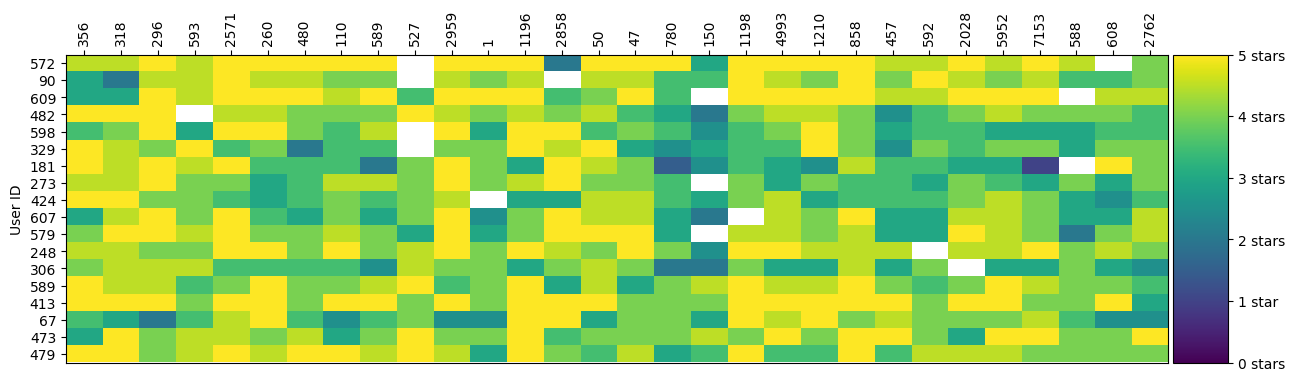

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    fig = plt.figure(figsize=(15, 4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection, interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]), minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]), minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        labels = most_rated_movies_users_selection.columns.astype(str).str[:40]  # Convert column names to strings
        ax.set_xticklabels(labels, minor=False, rotation=90)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel("User ID")

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(["5 stars", "4 stars", "3 stars", "2 stars", "1 star", "0 stars"])

    plt.show()

# Call the function
draw_movies_heatmap(most_rated_movies_users_selection)


In [49]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [50]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [53]:
from sklearn.cluster import KMeans

# Perform KMeans clustering with 20 clusters
predictions = KMeans(n_clusters=20, algorithm='lloyd', random_state=42).fit_predict(sparse_ratings)


### Predictions and Recommendation

In [57]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
predictions = KMeans(n_clusters=20, algorithm='lloyd').fit_predict(sparse_ratings)

# Create clustered DataFrame
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(),
                       pd.DataFrame({'group': predictions})], axis=1)

print("Clustered DataFrame created successfully.")
print(clustered.head())


Clustered DataFrame created successfully.
   index  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0      0                  4.0                               NaN   
1      1                  NaN                               3.0   
2      2                  NaN                               NaN   
3      3                  NaN                               NaN   
4      4                  NaN                               3.0   

   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  Matrix, The (1999)  \
0                  3.0                               4.0                 5.0   
1                  NaN                               NaN                 NaN   
2                  NaN                               NaN                 NaN   
3                  1.0                               5.0                 1.0   
4                  5.0                               NaN                 NaN   

   Star Wars: Episode IV - A New Hope (1977)  Jurassic Park (1993)  \
0   

In [61]:
import pandas as pd
import numpy as np
import difflib
from sklearn.cluster import KMeans

# Assuming user_movie_ratings and sparse_ratings are already defined
# If not, replace them with your actual dataset

# Step 1: Perform Clustering with KMeans
kmeans = KMeans(n_clusters=20, algorithm='lloyd', random_state=42)  # Fixed algorithm
predictions = kmeans.fit_predict(sparse_ratings)

# Step 2: Create the Clustered DataFrame
clustered = pd.concat([user_movie_ratings.reset_index(), pd.DataFrame({'group': predictions})], axis=1)

# Step 3: Select a Specific Cluster (e.g., Cluster 11)
cluster_number = 11
if 'group' in clustered.columns:
    cluster = clustered[clustered['group'] == cluster_number].drop(columns=['index', 'group'], errors='ignore')
else:
    raise ValueError("Error: 'group' column not found in clustered DataFrame.")

# Step 4: Search for a Movie in the Cluster
movie_name = "Matrix, The (1999)"
closest_match = difflib.get_close_matches(movie_name, cluster.columns, n=1)

if closest_match:
    movie_name = closest_match[0]
    print(f"Using closest match: {movie_name}")
    print(f"Mean rating in cluster: {cluster[movie_name].mean():.2f}")
else:
    print(f"Error: '{movie_name}' not found in cluster.")


Using closest match: Matrix, The (1999)
Mean rating in cluster: 3.81


In [62]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
userId,305.866667
'71 (2014),NaN
'Hellboy': The Seeds of Creation (2004),NaN
'Round Midnight (1986),NaN
'Salem's Lot (2004),NaN
'Til There Was You (1997),NaN
'Tis the Season for Love (2015),NaN
"'burbs, The (1989)",3.666667
'night Mother (1986),NaN
(500) Days of Summer (2009),1.500000


In [63]:
cluster

,userId,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
18,19,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
56,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
155,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,217,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
220,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN
265,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# Pick a user ID from the dataset
user_id = 7

# Ensure the user exists in the dataset
if user_id in cluster.index:
    # Get all this user's ratings
    user_2_ratings = cluster.loc[user_id, :]

    # Find unrated movies
    user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()].index

    # Compute average ratings for only unrated movies
    avg_ratings = cluster.mean().loc[user_2_unrated_movies]

    # Sort movies by highest average rating
    recommended_movies = avg_ratings.sort_values(ascending=False)[:20]

    # Display top 20 recommended movies
    print("Top 20 Movie Recommendations for User", user_id)
    print(recommended_movies)
else:
    print(f"Error: User ID {user_id} not found in dataset.")



Error: User ID 7 not found in dataset.


## Using Collaborative Filtering (With fast.ai)

In [23]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00


In [24]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [25]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [26]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [27]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [28]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [29]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [30]:
dls.show_batch()

,user,title,rating
0,585,"Neon Bible, The (1995)",2
1,252,Trainspotting (1996),5
2,881,Absolute Power (1997),3
3,357,Star Trek: First Contact (1996),5
4,518,Absolute Power (1997),3
5,234,Tin Men (1987),2
6,410,Apt Pupil (1998),4
7,747,Get on the Bus (1996),5
8,194,"Nightmare on Elm Street, A (1984)",2
9,30,"Abyss, The (1989)",4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [31]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

learn.fit_one_cycle(5, 5e-3, wd=0.1)

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [34]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [35]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [36]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [37]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3532), 'Spice World (1997)', 2.1153846153846154),
 (tensor(-0.3466),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3243),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3190), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3018), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2815), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2781), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2711), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2704), 'Airheads (1994)', 2.34375),
 (tensor(-0.2699), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2548), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2444), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2412), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2411), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2398), 'House

Or the ones with the best bias:

In [38]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5993), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5885), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5707), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5388), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5383), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5371), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5166), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5135), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.5092), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4995), 'Treasure of the Sierra Madre, The (1948)', 4.1),
 (tensor(0.4985), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4885), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4798), 'Amadeus (1984)', 4.163043478260869),
 (tensor(0.4646), 'Manchurian Candidate, The (1962)', 4.259541984732825),
 (tensor(0.4636), 'Close Shave, A (1995)', 4.491071428571429)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [39]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [40]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [41]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [42]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1398), 'Chinatown (1974)'),
 (tensor(1.1387), 'Ran (1985)'),
 (tensor(1.1380), 'Lawrence of Arabia (1962)'),
 (tensor(1.1177), 'Usual Suspects, The (1995)'),
 (tensor(1.1172), 'M (1931)'),
 (tensor(1.0760), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(1.0716), 'Treasure of the Sierra Madre, The (1948)'),
 (tensor(1.0460), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(1.0197), 'Godfather: Part II, The (1974)'),
 (tensor(1.0105), '12 Angry Men (1957)')]

And the worst:

In [43]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2716), 'Home Alone 3 (1997)'),
 (tensor(-1.0704), 'Flipper (1996)'),
 (tensor(-1.0532), 'Batman Forever (1995)'),
 (tensor(-1.0530), 'Jungle2Jungle (1997)'),
 (tensor(-1.0442), 'Spice World (1997)'),
 (tensor(-1.0427), 'Bio-Dome (1996)'),
 (tensor(-1.0279), 'Turbulence (1997)'),
 (tensor(-1.0080), 'Congo (1995)'),
 (tensor(-0.9882), 'Homeward Bound II: Lost in San Francisco (1996)'),
 (tensor(-0.9599), 'Relic, The (1997)')]

Same thing for our second dimension:

In [44]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [45]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2856), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0977), 'Braveheart (1995)'),
 (tensor(1.0818), 'Forrest Gump (1994)'),
 (tensor(1.0708), "Mr. Holland's Opus (1995)"),
 (tensor(1.0226), 'Titanic (1997)'),
 (tensor(0.9614), "It's a Wonderful Life (1946)"),
 (tensor(0.8668), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(0.8559), 'Back to the Future (1985)'),
 (tensor(0.8319), 'American President, The (1995)'),
 (tensor(0.8214), 'Cinderella (1950)')]

In [46]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9101), 'Cable Guy, The (1996)'),
 (tensor(-0.8337), 'To Die For (1995)'),
 (tensor(-0.7971), 'Lost Highway (1997)'),
 (tensor(-0.7921), 'Cabin Boy (1994)'),
 (tensor(-0.7913), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7777), 'Barbarella (1968)'),
 (tensor(-0.7598), 'Tank Girl (1995)'),
 (tensor(-0.7398), 'Stupids, The (1996)'),
 (tensor(-0.6968), 'Trees Lounge (1996)'),
 (tensor(-0.6964), 'Jude (1996)')]

And we can even plot the movies according to their scores on those dimensions:

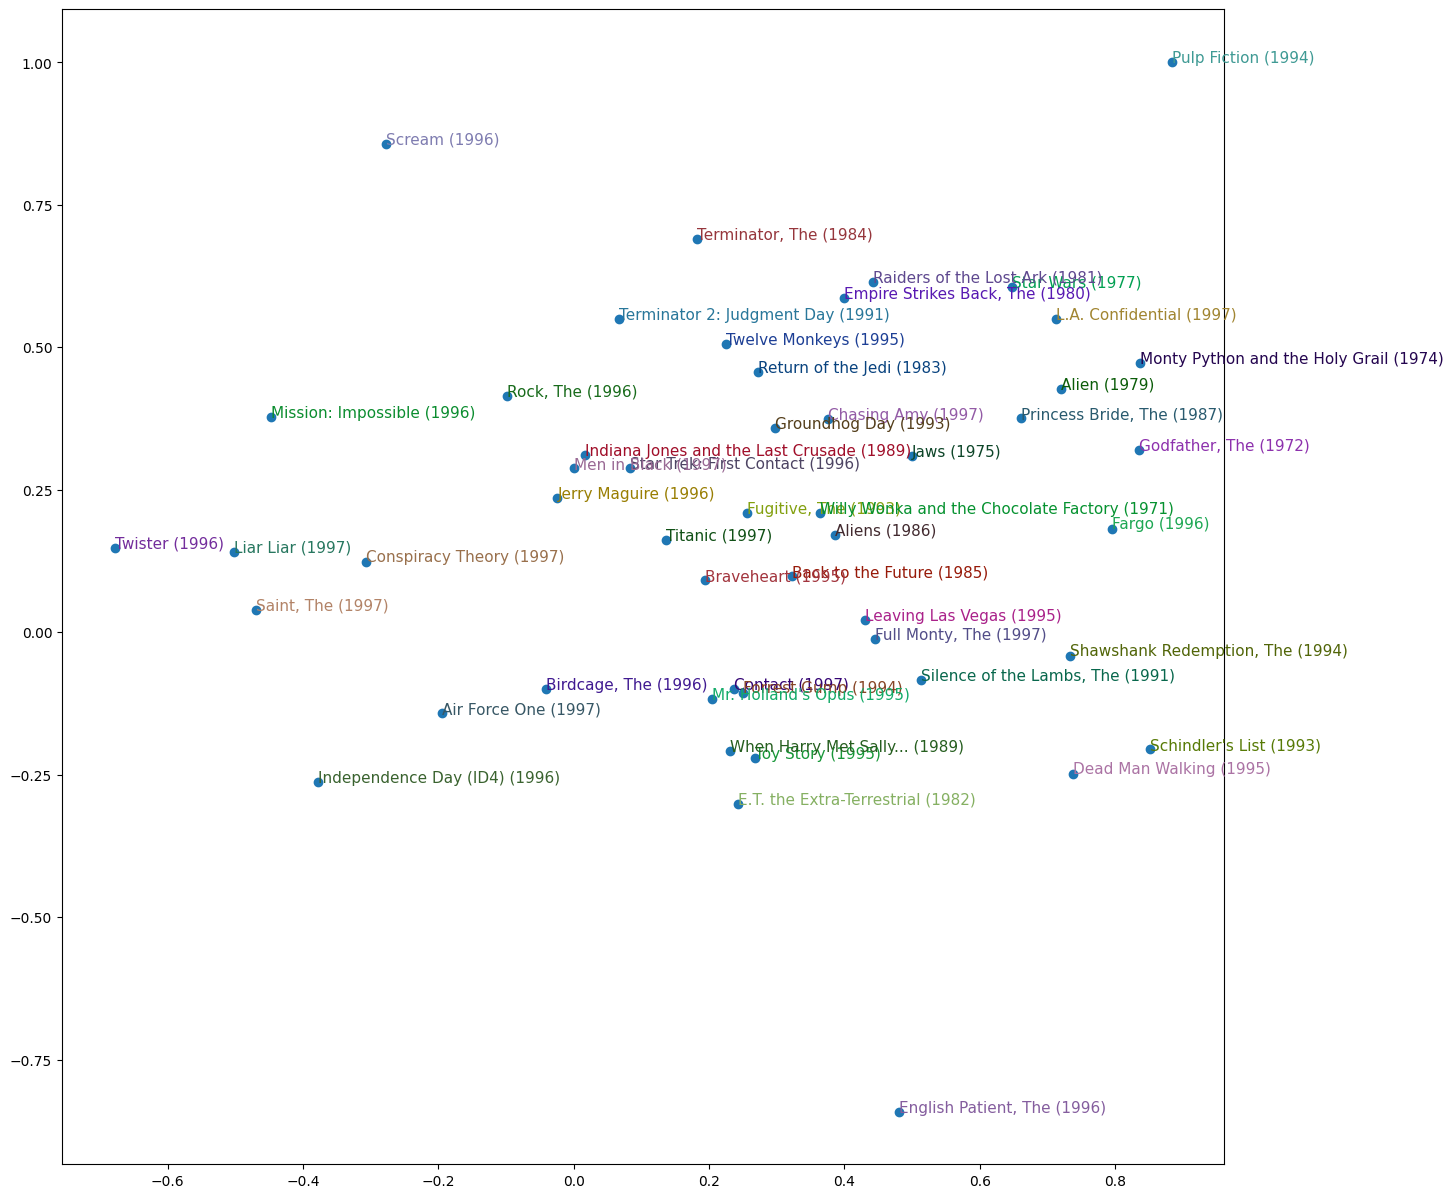

In [47]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [67]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505177 sha256=4df39c352dc6b4ebb38acd9a97c3f5a8d439a6eaa2dfd3c60e9cae72260b7fc9
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [71]:
import pandas as pd
import numpy as np
import time
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Step 1: Generate Synthetic Dataset (1000 users, 500 movies, random ratings)
np.random.seed(42)
num_users = 1000
num_movies = 500

user_ids = np.random.randint(1, 1001, 10000)  # Random user IDs
movie_ids = np.random.randint(1, 501, 10000)  # Random movie IDs
ratings = np.random.randint(1, 6, 10000)  # Ratings from 1 to 5

df = pd.DataFrame({'userId': user_ids, 'movieId': movie_ids, 'rating': ratings})

# Define reader and load dataset into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Step 2: Experiment with different collaborative filtering parameters
configs = [
    {"n_factors": 20, "n_epochs": 10, "lr_all": 0.005, "reg_all": 0.02},
    {"n_factors": 50, "n_epochs": 20, "lr_all": 0.005, "reg_all": 0.02},
    {"n_factors": 100, "n_epochs": 30, "lr_all": 0.005, "reg_all": 0.02},
    {"n_factors": 50, "n_epochs": 20, "lr_all": 0.01, "reg_all": 0.1},
]

results = []

for config in configs:
    svd_model = SVD(n_factors=config["n_factors"], n_epochs=config["n_epochs"],
                    lr_all=config["lr_all"], reg_all=config["reg_all"])

    start_time = time.time()
    cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    end_time = time.time()

    avg_rmse = np.mean(cv_results['test_rmse'])
    avg_mae = np.mean(cv_results['test_mae'])
    execution_time = end_time - start_time

    results.append({
        "n_factors": config["n_factors"],
        "n_epochs": config["n_epochs"],
        "lr_all": config["lr_all"],
        "reg_all": config["reg_all"],
        "RMSE": avg_rmse,
        "MAE": avg_mae,
        "Execution Time (s)": execution_time
    })

# Step 3: Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

   n_factors  n_epochs  lr_all  reg_all      RMSE       MAE  \
0         20        10   0.005     0.02  1.435880  1.243032   
1         50        20   0.005     0.02  1.461606  1.262975   
2        100        30   0.005     0.02  1.488451  1.280545   
3         50        20   0.010     0.10  1.489990  1.281042   

   Execution Time (s)  
0            0.226095  
1            0.342147  
2            1.888443  
3            0.997442  
